## Bloque I
Descomprimir el csv en formato gz

In [1]:
"""  
Importación de ficheros de AIRBNB. Preprocesado y cargado a la base de datos 

Obtenemos los datos desde https://insideairbnb.com/get-the-data/

Podríamos hacer scraping, obtener la fecha de la última actualización de Madrid y generar el enlace para descargarlo, pero no es necesario por que se actualiza cada mucho tiempo y no es necesario tener la última versión. Podemos cambiar la info procesable en la carpeta data manualmente.

"""
import os
import pandas as pd
import numpy as np
import datetime
#from config_bd import *
import requests
import sys
import gzip
import shutil
import matplotlib.pyplot as plt


In [2]:
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import cross_val_score


In [3]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

## Import Data
Carga del csv de detalle completo en pandas. Cambios de tipos e imputación

In [4]:
output_file_path = "./data/transform_listings_con_distancias_red_transporte.csv"

In [5]:
df = pd.read_csv(output_file_path, low_memory=False)

In [6]:
df.columns

Index(['property_id', 'listing_url', 'name', 'description',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'aire',
       'garaje', 'calefaccion', 'ascensor', 'DISTANCE_TO_METRO',
       'DISTANCE_TO_CERCANIAS', 'DISTANCE_TO_EMT', 'DISTANCE_TO_INTERURBANOS',
       'DISTANCE_TO_MLO'],
      dtype='object')

In [7]:
df

,property_id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,estimated_revenue_l365d,aire,garaje,calefaccion,ascensor,DISTANCE_TO_METRO,DISTANCE_TO_CERCANIAS,DISTANCE_TO_EMT,DISTANCE_TO_INTERURBANOS,DISTANCE_TO_MLO
0,70059,https://www.airbnb.com/rooms/70059,Tu hogar en centro de Madrid.,"Very nice, cozy and bright, right in the cente...",Universidad,Centro,40.423810,-3.710380,Entire rental unit,Entire home/apt,...,0.0,0,0,1,1,65.550156,891.965871,12.560164,900.746796,7264.107058
1,70310,https://www.airbnb.com/rooms/70310,"Heart of Malasaña Cozy, Quiet & Sunny Apartment",Cozy Apartment in great location in the center...,Universidad,Centro,40.422520,-3.702500,Entire rental unit,Entire home/apt,...,0.0,0,0,1,0,284.978036,631.600135,57.027035,1512.088715,7077.364017
2,72150,https://www.airbnb.com/rooms/72150,Sunny attic duplex flat with terrace next to Sol,"Nestled in the serene heart of Madrid, this re...",Embajadores,Centro,40.411500,-3.704490,Entire rental unit,Entire home/apt,...,17646.0,1,0,1,0,95.482753,605.845021,116.820438,1024.485790,8264.204209
3,84719,https://www.airbnb.com/rooms/84719,Cool Apart. (10min Center + WIFI),Cool and confortable 1 bedroom apartment for 2...,Embajadores,Centro,40.408660,-3.703740,Entire rental unit,Entire home/apt,...,0.0,1,0,1,1,241.641665,403.344436,112.846345,902.627954,6146.067885
4,86042,https://www.airbnb.com/rooms/86042,Cozy attic with intimate rooftop terrace+ elev...,"Nestled in Madrid's tranquil heart, this apart...",Embajadores,Centro,40.409390,-3.698120,Entire rental unit,Entire home/apt,...,27216.0,1,0,1,1,255.405162,608.010047,229.327136,436.363883,6629.512164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13866,1368974630547284843,https://www.airbnb.com/rooms/1368974630547284843,Coqueto estudio en tetuan!,Disconnect from the routine in this charming a...,Valdeacederas,Tetuán,40.464951,-3.704578,Entire rental unit,Entire home/apt,...,0.0,1,0,0,0,725.855648,2284.942162,37.612176,1187.201671,3617.510431
13867,1368981094706864086,https://www.airbnb.com/rooms/1368981094706864086,Bonito estudio en Tetuán!,Get away from routine at this unique and relax...,Valdeacederas,Tetuán,40.468355,-3.706939,Entire rental unit,Entire home/apt,...,0.0,1,0,0,0,860.673941,2438.746328,90.105679,1381.077584,5457.868016
13868,1368985680426539467,https://www.airbnb.com/rooms/1368985680426539467,Acogedor y nuevo ático con gran terraza (B),"Cozy penthouse floor with large terrace, locat...",Canillas,Hortaleza,40.464110,-3.647130,Entire rental unit,Entire home/apt,...,0.0,1,0,1,1,451.273298,2650.144067,94.570576,1761.401610,2441.782425
13869,1368986418960986344,https://www.airbnb.com/rooms/1368986418960986344,Elegante apartamento en Madrid!,Have fun with the whole family at this stylish...,San Isidro,Carabanchel,40.395983,-3.730953,Entire rental unit,Entire home/apt,...,0.0,1,0,0,0,689.318940,1180.965436,259.122214,769.248479,3699.565428


In [8]:
df.shape

(13871, 28)

Eliminamos las habitaciones, casas compartidas, hoteles, etc, solo queremos VIVIENDAS COMPLETAS

In [9]:
# df['property_type'].value_counts()
# df['room_type'].value_counts()

df = df[df['room_type']== 'Entire home/apt'].copy()
df['room_type'].value_counts()

room_type
Entire home/apt    13871
Name: count, dtype: int64

conversión de tipos

In [10]:
df['accommodates'] = df['accommodates'].astype(int)
df['bathrooms'] = df['bathrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)
df['bedrooms'] = df['bedrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['minimum_nights'] = df['minimum_nights'].astype(int)
df['maximum_nights'] = df['maximum_nights'].astype(int)
df['estimated_occupancy_l365d'] = df['estimated_occupancy_l365d'].astype(int)

<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
/var/folders/y1/nqw3rhqs1xv4s4gzlmjk02680000gn/T/ipykernel_44319/768565196.py:4: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)


imputamos una habitación y un baño cuando esta información no está rellena, asumiendo que habiendo retirado las propiedades compartidas, podemos interpretar que los estudios, lofts, etc todos van a tener al menos una habitación y baño o equivalente. (Sofá cama, etc).

*También se podría imputar las habitaciones dividiendo los "acommodates" entre dos pero creo que este método es más conservador.*

In [11]:
df

,property_id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,estimated_revenue_l365d,aire,garaje,calefaccion,ascensor,DISTANCE_TO_METRO,DISTANCE_TO_CERCANIAS,DISTANCE_TO_EMT,DISTANCE_TO_INTERURBANOS,DISTANCE_TO_MLO
0,70059,https://www.airbnb.com/rooms/70059,Tu hogar en centro de Madrid.,"Very nice, cozy and bright, right in the cente...",Universidad,Centro,40.423810,-3.710380,Entire rental unit,Entire home/apt,...,0.0,0,0,1,1,65.550156,891.965871,12.560164,900.746796,7264.107058
1,70310,https://www.airbnb.com/rooms/70310,"Heart of Malasaña Cozy, Quiet & Sunny Apartment",Cozy Apartment in great location in the center...,Universidad,Centro,40.422520,-3.702500,Entire rental unit,Entire home/apt,...,0.0,0,0,1,0,284.978036,631.600135,57.027035,1512.088715,7077.364017
2,72150,https://www.airbnb.com/rooms/72150,Sunny attic duplex flat with terrace next to Sol,"Nestled in the serene heart of Madrid, this re...",Embajadores,Centro,40.411500,-3.704490,Entire rental unit,Entire home/apt,...,17646.0,1,0,1,0,95.482753,605.845021,116.820438,1024.485790,8264.204209
3,84719,https://www.airbnb.com/rooms/84719,Cool Apart. (10min Center + WIFI),Cool and confortable 1 bedroom apartment for 2...,Embajadores,Centro,40.408660,-3.703740,Entire rental unit,Entire home/apt,...,0.0,1,0,1,1,241.641665,403.344436,112.846345,902.627954,6146.067885
4,86042,https://www.airbnb.com/rooms/86042,Cozy attic with intimate rooftop terrace+ elev...,"Nestled in Madrid's tranquil heart, this apart...",Embajadores,Centro,40.409390,-3.698120,Entire rental unit,Entire home/apt,...,27216.0,1,0,1,1,255.405162,608.010047,229.327136,436.363883,6629.512164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13866,1368974630547284843,https://www.airbnb.com/rooms/1368974630547284843,Coqueto estudio en tetuan!,Disconnect from the routine in this charming a...,Valdeacederas,Tetuán,40.464951,-3.704578,Entire rental unit,Entire home/apt,...,0.0,1,0,0,0,725.855648,2284.942162,37.612176,1187.201671,3617.510431
13867,1368981094706864086,https://www.airbnb.com/rooms/1368981094706864086,Bonito estudio en Tetuán!,Get away from routine at this unique and relax...,Valdeacederas,Tetuán,40.468355,-3.706939,Entire rental unit,Entire home/apt,...,0.0,1,0,0,0,860.673941,2438.746328,90.105679,1381.077584,5457.868016
13868,1368985680426539467,https://www.airbnb.com/rooms/1368985680426539467,Acogedor y nuevo ático con gran terraza (B),"Cozy penthouse floor with large terrace, locat...",Canillas,Hortaleza,40.464110,-3.647130,Entire rental unit,Entire home/apt,...,0.0,1,0,1,1,451.273298,2650.144067,94.570576,1761.401610,2441.782425
13869,1368986418960986344,https://www.airbnb.com/rooms/1368986418960986344,Elegante apartamento en Madrid!,Have fun with the whole family at this stylish...,San Isidro,Carabanchel,40.395983,-3.730953,Entire rental unit,Entire home/apt,...,0.0,1,0,0,0,689.318940,1180.965436,259.122214,769.248479,3699.565428


In [12]:
# df[(df['bathrooms'] == 0)& (df['bedrooms']==0)]
df['bathrooms'] = df['bathrooms'].replace(0,1)
df['bedrooms'] = df['bedrooms'].replace(0,1)

In [13]:
df = df.rename(columns={'id':'property_id'})

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   13871 non-null  int64  
 1   listing_url                   13871 non-null  object 
 2   name                          13871 non-null  object 
 3   description                   13510 non-null  object 
 4   neighbourhood_cleansed        13871 non-null  object 
 5   neighbourhood_group_cleansed  13871 non-null  object 
 6   latitude                      13871 non-null  float64
 7   longitude                     13871 non-null  float64
 8   property_type                 13871 non-null  object 
 9   room_type                     13871 non-null  object 
 10  accommodates                  13871 non-null  int64  
 11  bathrooms                     13871 non-null  int64  
 12  bedrooms                      13871 non-null  int64  
 13  a

#### Data Import of Rentas Ayto Madrid

In [15]:
#Import data from Ayto de Madrid, rentas
df_rentas = pd.read_csv('../ayto_madrid/Datos_Rentas_Madrid_2022.csv',delimiter=";")
df_rentas.head()

,Distrito,Renta neta media por persona,Renta neta media por hogar,Media de la renta neta por unidad de consumo,Mediana de la renta neta por unidad de consumo,Renta bruta media por persona,Renta media bruta por hogar
0,01. Centro,20.587,41.059,28.500,22.05,27.030,53.908
1,02. Arganzuela,21.383,49.236,31.038,28.35,27.431,63.160
2,03. Retiro,25.407,60.762,37.916,31.85,33.396,79.868
3,04. Salamanca,28.140,64.925,42.592,31.15,38.751,89.407
4,05. Chamartín,30.506,74.842,47.564,34.65,42.678,104.706


In [16]:
df_rentas.dtypes

Distrito                                           object
Renta neta media por persona                      float64
Renta neta media por hogar                        float64
Media de la renta neta por unidad de consumo      float64
Mediana de la renta neta por unidad de consumo    float64
Renta bruta media por persona                     float64
Renta media bruta por hogar                       float64
dtype: object

In [17]:
for col in df_rentas.select_dtypes(include='float'):
    df_rentas[col] = df_rentas[col].apply(lambda x: x * 1000)

df_rentas.head()


,Distrito,Renta neta media por persona,Renta neta media por hogar,Media de la renta neta por unidad de consumo,Mediana de la renta neta por unidad de consumo,Renta bruta media por persona,Renta media bruta por hogar
0,01. Centro,20587.0,41059.0,28500.0,22050.0,27030.0,53908.0
1,02. Arganzuela,21383.0,49236.0,31038.0,28350.0,27431.0,63160.0
2,03. Retiro,25407.0,60762.0,37916.0,31850.0,33396.0,79868.0
3,04. Salamanca,28140.0,64925.0,42592.0,31150.0,38751.0,89407.0
4,05. Chamartín,30506.0,74842.0,47564.0,34650.0,42678.0,104706.0


In [18]:
df['neighbourhood_group_cleansed'].unique()

array(['Centro', 'Arganzuela', 'Chamberí', 'Fuencarral - El Pardo',
       'Hortaleza', 'Moncloa - Aravaca', 'Retiro',
       'San Blas - Canillejas', 'Barajas', 'Moratalaz', 'Ciudad Lineal',
       'Salamanca', 'Chamartín', 'Tetuán', 'Villaverde', 'Carabanchel',
       'Latina', 'Vicálvaro', 'Puente de Vallecas', 'Usera',
       'Villa de Vallecas'], dtype=object)

In [19]:
df_rentas['Distrito'].unique()

array(['01. Centro', '02. Arganzuela', '03. Retiro', '04. Salamanca',
       '05. Chamartín', '06. Tetuán', '07. Chamberí',
       '08. Fuencarral-El Pardo', '09. Moncloa-Aravaca', '10. Latina',
       '11. Carabanchel', '12. Usera', '13. Puente de Vallecas',
       '14. Moratalaz', '15. Ciudad Lineal', '16. Hortaleza',
       '17. Villaverde', '18. Villa de Vallecas', '19. Vicálvaro',
       '20. San Blas-Canillejas', '21. Barajas'], dtype=object)

In [20]:
df_rentas['Distrito'] = df_rentas['Distrito'].str[4:]
df_rentas['Distrito'] = df_rentas['Distrito'].apply(lambda x: x.replace('-', ' - ') if '-' in x else x)
df_rentas.head(21)


,Distrito,Renta neta media por persona,Renta neta media por hogar,Media de la renta neta por unidad de consumo,Mediana de la renta neta por unidad de consumo,Renta bruta media por persona,Renta media bruta por hogar
0,Centro,20587.0,41059.0,28500.0,22050.0,27030.0,53908.0
1,Arganzuela,21383.0,49236.0,31038.0,28350.0,27431.0,63160.0
2,Retiro,25407.0,60762.0,37916.0,31850.0,33396.0,79868.0
3,Salamanca,28140.0,64925.0,42592.0,31150.0,38751.0,89407.0
4,Chamartín,30506.0,74842.0,47564.0,34650.0,42678.0,104706.0
5,Tetuán,18062.0,42465.0,25955.0,20650.0,22890.0,53816.0
6,Chamberí,27076.0,60032.0,40145.0,31150.0,36934.0,81889.0
7,Fuencarral - El Pardo,21947.0,58214.0,34241.0,28350.0,28798.0,76386.0
8,Moncloa - Aravaca,26694.0,68238.0,41666.0,30450.0,36592.0,93541.0
9,Latina,14375.0,35669.0,20833.0,18550.0,17267.0,42843.0


In [21]:
print(sorted(df['neighbourhood_group_cleansed'].unique()))
print(sorted(df_rentas['Distrito'].unique()))

['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín', 'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza', 'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas', 'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera', 'Vicálvaro', 'Villa de Vallecas', 'Villaverde']
['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín', 'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza', 'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas', 'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera', 'Vicálvaro', 'Villa de Vallecas', 'Villaverde']


## Functions

In [22]:


models = {"lr":linear_model.LinearRegression(),
          "ridge":linear_model.Ridge(alpha=0),
          "lasso":linear_model.Lasso(),
          "SGD":linear_model.SGDRegressor(),
          "HuberRegressor":linear_model.HuberRegressor(),
          "Elastic":linear_model.ElasticNet(),
          #"XGBRegressor":XGBRegressor()
          }


def get_results(X_train, y_train, X_test, y_test ):
    metrics_analysis = []
    for m, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)

        mse = metrics.mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
        r2 = metrics.r2_score(y_test, y_test_pred)

        metrics_ = pd.Series(name=m, data={"r2": r2, "mse": mse, "rmse": rmse, "mape": mape})
        metrics_analysis.append(metrics_)
    return pd.DataFrame(metrics_analysis)


df_rentas['renta_bin'] = pd.cut(
    df_rentas['Renta neta media por hogar'].sort_values(),
    bins=5,
    labels=['muy_bajo','bajo','medio','alto','muy_alto'],
    include_lowest=True
)
df_rentas[['Distrito', 'Renta neta media por hogar', 'renta_bin']]


def get_renta_bin(distrito:str):
    # Busca el distrito en df_rentas y devuelve el valor de 'renta_bin'
    row = df_rentas[df_rentas['Distrito'] == distrito]
    if not row.empty:
        return row['renta_bin'].values[0]
    else:
        return None
    

## Funciones para calcular distancia minima a la estacion del metro
from math import radians, sin, cos, sqrt, atan2

def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


def get_nearest_metro_distance(row, df_metro):
    min_distance = float('inf')
    for _, metro_row in df_metro.iterrows():
        distance = haversine(row['longitude'], row['latitude'], metro_row['stop_lon'], metro_row['stop_lat'])
        if distance < min_distance:
            min_distance = distance
    return min_distance
#####

## Understand Data, Get More Data and Clean data
Importamos a la base de datos. 
**Requiere haber creado la tabla** <code>01_CREATE TABLE bnb_property.sql</code>

### Property type and room_type

Filter to consider only the property type that correct

In [23]:
df["property_type"].value_counts()

property_type
Entire rental unit           12392
Entire condo                   420
Entire loft                    395
Entire serviced apartment      275
Entire home                    247
Entire guesthouse               20
Tiny home                       19
Entire place                    17
Entire vacation home            17
Entire guest suite              16
Camper/RV                       12
Entire townhouse                10
Casa particular                  7
Entire villa                     7
Entire chalet                    5
Room in aparthotel               3
Entire cabin                     3
Religious building               2
Floor                            2
Hut                              1
Yurt                             1
Name: count, dtype: int64

Anteriormente seleccionnado los registros con room_type =  'Entire home/apt'.
Ahora quitamos los registros que no se corresponden a una vivienda en funcion del room_type

In [24]:
property_types_to_remove = ['Camper/RV', 'Room in aparthotel', 'Entire cabin','Hut','Yurt','Entire Bungalow']
df = df[~df['property_type'].isin(property_types_to_remove)].copy()

In [25]:
df['property_type'].value_counts()

property_type
Entire rental unit           12392
Entire condo                   420
Entire loft                    395
Entire serviced apartment      275
Entire home                    247
Entire guesthouse               20
Tiny home                       19
Entire place                    17
Entire vacation home            17
Entire guest suite              16
Entire townhouse                10
Casa particular                  7
Entire villa                     7
Entire chalet                    5
Religious building               2
Floor                            2
Name: count, dtype: int64

In [26]:
df[['accommodates','bedrooms','bathrooms']]

,accommodates,bedrooms,bathrooms
0,2,1,1
1,2,1,1
2,6,3,1
3,2,1,1
4,6,3,1
...,...,...,...
13866,2,1,1
13867,2,1,1
13868,3,1,1
13869,5,2,1


### Amenities

In [27]:
import ast

def get_all_amenities(data):
    """
    Devuelve un set con todos los amenities únicos presentes en la columna 'amenities' del DataFrame.
    """
    all_amenities = set()
    for amenities_str in data["amenities"]:
        try:
            amenities_list = ast.literal_eval(amenities_str)
            all_amenities.update(amenities_list)
        except Exception:
            continue
    return all_amenities

In [28]:
amenities = get_all_amenities(df)

In [29]:
len(amenities)

2663

In [30]:
amentities_exclude = ['condition','pool','BBQ','sauna','conditioner','Exercise equipment','Paid Parking','sound system','Housekeeping','book','amazon','soap','shampoo','hair dryer','iron','washer','dryer','TV','internet','wifi','kitchen','microwave','refrigerator','stove','oven','dishwasher','coffee maker','toaster']

In [31]:
for exclude_amenity in amentities_exclude:
     amenities = [value for value in amenities if str.lower(exclude_amenity) not in str.lower(value)]


In [32]:
len(amenities)

241

In [33]:
amenities

['Baby safety gates',
 'Clothing storage: closet',
 'Fire pit',
 'Paid resort access',
 'Paid high chair - available upon request',
 'Rice maker',
 'Paid crib',
 'Arcade games',
 'Standalone high chair - available upon request',
 'Heating',
 'Free parking garage on premises – 51 spaces',
 'Central heating',
 'Shared gym in building',
 'Game console',
 'Free parking on premises',
 'City skyline view',
 'Private entrance',
 'Private hot tub',
 'Smoke alarm',
 'Host greets you',
 'Paid pack ’n play/travel crib',
 'Window AC unit',
 'Booster seat high chair',
 'Pack ’n play/Travel crib - available upon request',
 'Baking sheet',
 'Radiant heating',
 'Game console: Nintendo Wii and PS3',
 'Standalone high chair',
 'Paid clamp on table seat high chair - always at the listing',
 'Pack ’n play/Travel crib',
 'Table corner guards',
 'Indoor fireplace: gas',
 'Free parking garage on premises – 17 spaces',
 'Dining table',
 'Shared hot tub',
 'Waterfront',
 'Bidet',
 'Park view',
 'Clothing stora

##### Heating

In [34]:
[value for value in amenities if 'heating' in str.lower(value)]

['Heating',
 'Central heating',
 'Radiant heating',
 'Heating - split type ductless system']

In [35]:
df['calefaccion'] = df['amenities'].apply(lambda x: 1 if 'heating' in x.lower() else 0)

In [36]:
df['calefaccion'].value_counts()

calefaccion
1    11986
0     1865
Name: count, dtype: int64

##### Pool

In [37]:
[value for value in amenities if ('pool' in str.lower(value)) and ('whirlpool' not in str.lower(value)) and ('whirpool' not in str.lower(value))]

[]

- Pool

In [38]:
df['pool'] = df['amenities'].apply(lambda x: 1 if ('pool' in str.lower(x)) and ('whirlpool' not in str.lower(x)) and ('whirpool' not in str.lower(x)) else 0)

In [39]:
df['pool'].value_counts()

pool
0    13251
1      600
Name: count, dtype: int64

##### Parking

In [40]:
[value for value in amenities if 'free parking' in str.lower(value)]

['Free parking garage on premises – 51 spaces',
 'Free parking on premises',
 'Free parking garage on premises – 17 spaces',
 'Free parking garage on premises',
 'Free parking garage on premises – 2 spaces',
 'Free parking on premises – 1 space',
 'Free parking garage on premises – 81 spaces',
 'Free parking garage on premises – 1 space']

In [41]:
df['garaje'] = df['amenities'].apply(lambda x: 1 if 'free parking' in x.lower() else 0)

In [42]:
df['garaje'].value_counts()

garaje
0    13153
1      698
Name: count, dtype: int64

##### Air conditioning

In [43]:
[value for value in amenities if 'air conditi' in str.lower(value)]

[]

In [44]:
df['aire_acondicionado'] = df['amenities'].apply(lambda x: 1 if 'air conditi' in str.lower(x) else 0)

In [45]:
df['aire_acondicionado'].value_counts()

aire_acondicionado
1    10218
0     3633
Name: count, dtype: int64

##### Elevator

In [46]:
[value for value in amenities if 'elevator' in str.lower(value)]

['Elevator']

In [47]:
df['ascensor'] = df['amenities'].apply(lambda x: 1 if 'elevator' in str.lower(x) else 0)

In [48]:
df['ascensor'].value_counts()

ascensor
0    7188
1    6663
Name: count, dtype: int64

##### Movilidad reducida

In [49]:
[value for value in amenities if 'single level home' in str.lower(value)]

['Single level home']

In [50]:
df['movilidad_reducida'] = df['amenities'].apply(lambda x: 1 if 'single level home' in str.lower(x) else 0)

In [51]:
df['movilidad_reducida'].value_counts()

movilidad_reducida
0    12206
1     1645
Name: count, dtype: int64

In [52]:
#OJO, no tiene sentido no tener ascensor y movilidad reducida
df[df['movilidad_reducida'] == 1][["listing_url","movilidad_reducida","ascensor"]]

,listing_url,movilidad_reducida,ascensor
3,https://www.airbnb.com/rooms/84719,1,1
12,https://www.airbnb.com/rooms/684564,1,1
29,https://www.airbnb.com/rooms/280733,1,1
32,https://www.airbnb.com/rooms/751527,1,1
34,https://www.airbnb.com/rooms/752424,1,1
...,...,...,...
13777,https://www.airbnb.com/rooms/1362319075445033257,1,0
13780,https://www.airbnb.com/rooms/1366625139989288134,1,1
13807,https://www.airbnb.com/rooms/1367400865560226670,1,1
13817,https://www.airbnb.com/rooms/1365826061924320510,1,0


### Otros

Columna "name_description" , nos sirve para recoger mas datos y eliminar duplicados

In [53]:
df["name_description"] = df["name"].fillna(" ").str.lower() + " and " + df["description"].fillna(" ").str.lower()
df["name_description"].isnull().sum()


0

##### Terrace

In [54]:
df["terraza"] = df["name_description"].apply(lambda x: 1 if "terrace" in x else 0)

In [55]:
df["terraza"].value_counts()

terraza
0    12764
1     1087
Name: count, dtype: int64

##### Balconies

In [56]:
df["balcon"] = df["name_description"].apply(lambda x: 1 if "balcon" in x else 0)

In [57]:
df["balcon"].value_counts()

balcon
0    13004
1      847
Name: count, dtype: int64

In [58]:
df[ (df['description'].str.contains('terrace', na=False))]

,property_id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,DISTANCE_TO_CERCANIAS,DISTANCE_TO_EMT,DISTANCE_TO_INTERURBANOS,DISTANCE_TO_MLO,pool,aire_acondicionado,movilidad_reducida,name_description,terraza,balcon
2,72150,https://www.airbnb.com/rooms/72150,Sunny attic duplex flat with terrace next to Sol,"Nestled in the serene heart of Madrid, this re...",Embajadores,Centro,40.411500,-3.704490,Entire rental unit,Entire home/apt,...,605.845021,116.820438,1024.485790,8264.204209,0,1,0,sunny attic duplex flat with terrace next to s...,1,0
4,86042,https://www.airbnb.com/rooms/86042,Cozy attic with intimate rooftop terrace+ elev...,"Nestled in Madrid's tranquil heart, this apart...",Embajadores,Centro,40.409390,-3.698120,Entire rental unit,Entire home/apt,...,608.010047,229.327136,436.363883,6629.512164,0,1,0,cozy attic with intimate rooftop terrace+ elev...,1,0
10,198296,https://www.airbnb.com/rooms/198296,Very quiet central top floor with 2 terraces,Beautiful central top floor apartment with two...,Universidad,Centro,40.425890,-3.705650,Entire rental unit,Entire home/apt,...,1027.068016,154.840978,1359.030174,6864.978214,0,0,0,very quiet central top floor with 2 terraces a...,1,0
40,342095,https://www.airbnb.com/rooms/342095,Lovely apartment CENTRAL MADRID !,Ideal place to visiting and enjoying Madrid wa...,Embajadores,Centro,40.410150,-3.697970,Entire rental unit,Entire home/apt,...,683.028489,152.197393,472.340515,8208.370847,0,1,0,lovely apartment central madrid ! and ideal pl...,1,0
45,768311,https://www.airbnb.com/rooms/768311,Precioso estudio y terraza en el corazón de Ma...,Beautiful studio in Madrid's most lively neigh...,Palacio,Centro,40.411660,-3.710070,Entire loft,Entire home/apt,...,826.504541,129.281314,1234.882498,5707.905501,0,1,0,precioso estudio y terraza en el corazón de ma...,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13662,1360059324279556027,https://www.airbnb.com/rooms/1360059324279556027,Luxury apartment in Chamartín by beBalmy,Elegant 115 m2 apartment with large terrace an...,Castilla,Chamartín,40.467512,-3.686079,Entire rental unit,Entire home/apt,...,594.307691,72.829806,241.804210,2151.269031,0,1,0,luxury apartment in chamartín by bebalmy and e...,1,0
13802,1367208187303882310,https://www.airbnb.com/rooms/1367208187303882310,Central Sol residences 5-I,This listing has a strategic location - it wil...,Cortes,Centro,40.415140,-3.700600,Entire rental unit,Entire home/apt,...,284.108978,83.923422,1011.207323,7765.255615,0,1,0,central sol residences 5-i and this listing ha...,1,0
13808,1367400905039791308,https://www.airbnb.com/rooms/1367400905039791308,La Terraza Vista Alegre,Modern 1-Bedroom with Terrace in Vista Alegre ...,Vista Alegre,Carabanchel,40.390433,-3.742443,Entire rental unit,Entire home/apt,...,982.960617,125.834662,239.603890,2817.912466,0,1,0,la terraza vista alegre and modern 1-bedroom w...,1,0
13861,1368903492306099065,https://www.airbnb.com/rooms/1368903492306099065,Edgar Neville III,"Bathed in natural light, this stylish apartmen...",Cuatro Caminos,Tetuán,40.450625,-3.695489,Entire rental unit,Entire home/apt,...,518.832162,85.717472,1827.409777,4079.840210,0,1,0,"edgar neville iii and bathed in natural light,...",1,0


##### Jardin

In [59]:
df["jardin"] = df["name_description"].apply(lambda x: 1 if "garden" in x else 0)

In [60]:
df["jardin"].value_counts()
#Columna no concluyente, garden view...

jardin
0    13592
1      259
Name: count, dtype: int64

In [61]:
df[df['jardin'] == 1][["listing_url","jardin","description"]]
df[df['jardin'] == 1][["listing_url","jardin","description"]]

,listing_url,jardin,description
33,https://www.airbnb.com/rooms/751530,1,"Modern apartment, comfortable in the center of..."
36,https://www.airbnb.com/rooms/755587,1,"Modern, comfortable apartment in the middle of..."
43,https://www.airbnb.com/rooms/761159,1,"Modern, comfortable apartment in the heart of ..."
89,https://www.airbnb.com/rooms/923140,1,It is our Home when are in Madrid<br />Whole h...
137,https://www.airbnb.com/rooms/1256157,1,"Situated in the vibrant La Latina neighborhod,..."
...,...,...,...
13338,https://www.airbnb.com/rooms/1344736366819913608,1,This studio is situated in an unbeatable locat...
13584,https://www.airbnb.com/rooms/1355647187610947785,1,"Renovated family house in Chamartin, near the ..."
13697,https://www.airbnb.com/rooms/1360726822768311194,1,Seasonal rental in the heart of Madrid.<br /><...
13699,https://www.airbnb.com/rooms/1360745730432902867,1,"1 bedroom and 1 bathroom apartment, with 45 m2..."


##### Meters

In [62]:
df[(df["name_description"].str.contains("0m"))][["listing_url","name_description"]]

,listing_url,name_description
3,https://www.airbnb.com/rooms/84719,cool apart. (10min center + wifi) and cool and...
13,https://www.airbnb.com/rooms/204570,lovely 110m2 home - best location! and spaciou...
20,https://www.airbnb.com/rooms/721377,40m2 loft great for student 100m wf and baseme...
30,https://www.airbnb.com/rooms/281224,the royal palace opera central apartment and a...
77,https://www.airbnb.com/rooms/871387,designer loft unbeatable location gran via and...
...,...,...
13649,https://www.airbnb.com/rooms/1359649495299627125,piso de un dormitorio en tetuan and get away f...
13671,https://www.airbnb.com/rooms/1360101264409120935,apartamento de 1 dormitorio - oshun valdecanil...
13717,https://www.airbnb.com/rooms/1361323076472811324,singular apartament in delicias by bebalmy and...
13734,https://www.airbnb.com/rooms/1364476792835645609,monthly 3br 2bth 6 beds and this cozy and grea...


In [63]:
df[(df["name_description"].str.contains(" m2 ")) | (df["name_description"].str.contains("m2"))][["listing_url","name_description"]]

,listing_url,name_description
13,https://www.airbnb.com/rooms/204570,lovely 110m2 home - best location! and spaciou...
20,https://www.airbnb.com/rooms/721377,40m2 loft great for student 100m wf and baseme...
61,https://www.airbnb.com/rooms/449218,"central, fully equipped, best price and locate..."
77,https://www.airbnb.com/rooms/871387,designer loft unbeatable location gran via and...
112,https://www.airbnb.com/rooms/1085898,3flats ideally located! flat x:4people and spa...
...,...,...
13662,https://www.airbnb.com/rooms/1360059324279556027,luxury apartment in chamartín by bebalmy and e...
13692,https://www.airbnb.com/rooms/1363706454959121782,toque de madrid para 8 en tesoro 6 and several...
13699,https://www.airbnb.com/rooms/1360745730432902867,apartamento en chamartín and 1 bedroom and 1 b...
13717,https://www.airbnb.com/rooms/1361323076472811324,singular apartament in delicias by bebalmy and...


In [64]:
df[(df["name_description"].str.contains(" m² ")) | (df["name_description"].str.contains("m²"))][["listing_url","name_description"]]

,listing_url,name_description
89,https://www.airbnb.com/rooms/923140,penhouse with lovely terrace and it is our hom...
201,https://www.airbnb.com/rooms/2650925,"amazing plaza mayor view, apt in the city cent..."
202,https://www.airbnb.com/rooms/2652829,"charming plaza mayor view, city center apt in ..."
267,https://www.airbnb.com/rooms/3584830,rooftop in the heart of madrid - plaza mayor v...
277,https://www.airbnb.com/rooms/3610905,appartment in malasaña and a 70m² renewed apar...
...,...,...
13671,https://www.airbnb.com/rooms/1360101264409120935,apartamento de 1 dormitorio - oshun valdecanil...
13687,https://www.airbnb.com/rooms/1363628607171548582,house of arts - la latina and the <b>apartment...
13745,https://www.airbnb.com/rooms/1361514406168377855,"modern, brand-new apartment for 4 in las letra..."
13794,https://www.airbnb.com/rooms/1365318262628960289,"encanto madrileño para 2, vive en calle del ág..."


In [65]:
import re
def get_meters(data):
    """
    Devuelve un set con todos los metros únicos presentes en la columna 'name_description' del DataFrame.
    """
    matches_1 = re.findall(r'(\d+)\s?m²', data)
    matches_2 = re.findall(r'(\d+)\s?m2', data)
    if matches_1:
        return int(matches_1[0])
    if matches_2:
        return int(matches_2[0])

    return None

In [66]:
df["meters"] = df["name_description"].apply(get_meters)

In [67]:
df[~df["meters"].isnull()][["listing_url","name_description","meters","price","estimated_occupancy_l365d","estimated_revenue_l365d"]]

,listing_url,name_description,meters,price,estimated_occupancy_l365d,estimated_revenue_l365d
13,https://www.airbnb.com/rooms/204570,lovely 110m2 home - best location! and spaciou...,110.0,177.0,48,8496.0
20,https://www.airbnb.com/rooms/721377,40m2 loft great for student 100m wf and baseme...,40.0,100.0,14,1400.0
61,https://www.airbnb.com/rooms/449218,"central, fully equipped, best price and locate...",25.0,64.0,255,16320.0
77,https://www.airbnb.com/rooms/871387,designer loft unbeatable location gran via and...,45.0,114.0,192,21888.0
89,https://www.airbnb.com/rooms/923140,penhouse with lovely terrace and it is our hom...,80.0,225.0,190,42750.0
...,...,...,...,...,...,...
13717,https://www.airbnb.com/rooms/1361323076472811324,singular apartament in delicias by bebalmy and...,50.0,103.0,0,0.0
13734,https://www.airbnb.com/rooms/1364476792835645609,monthly 3br 2bth 6 beds and this cozy and grea...,90.0,251.0,0,0.0
13745,https://www.airbnb.com/rooms/1361514406168377855,"modern, brand-new apartment for 4 in las letra...",75.0,182.0,0,0.0
13794,https://www.airbnb.com/rooms/1365318262628960289,"encanto madrileño para 2, vive en calle del ág...",50.0,92.0,0,0.0


In [68]:
df.sort_values(by=['price'], ascending=False)

,property_id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,DISTANCE_TO_INTERURBANOS,DISTANCE_TO_MLO,pool,aire_acondicionado,movilidad_reducida,name_description,terraza,balcon,jardin,meters
9116,1087700981397177073,https://www.airbnb.com/rooms/1087700981397177073,Stunning duplex | Terrace & BBQ | Free Parking,Discover our duplex in the North Zone of Madri...,Valdeacederas,Tetuán,40.467680,-3.708650,Entire rental unit,Entire home/apt,...,1518.386806,3805.919610,0,1,0,stunning duplex | terrace & bbq | free parking...,1,0,0,NaN
3177,45249073,https://www.airbnb.com/rooms/45249073,Captivating Apartment in Madrid near El Retiro...,Detach yourself from work commitments and fami...,Palomeras Bajas,Puente de Vallecas,40.391400,-3.664250,Entire rental unit,Entire home/apt,...,1067.819265,9856.407604,0,1,0,captivating apartment in madrid near el retiro...,0,1,0,NaN
1103,18816591,https://www.airbnb.com/rooms/18816591,PUERTA DEL ANGEL,"Located next to Paseo De Extremadura, a few me...",Puerta del Angel,Latina,40.409160,-3.732560,Entire rental unit,Entire home/apt,...,1561.235599,3809.307831,0,1,0,puerta del angel and located next to paseo de ...,1,0,1,NaN
7501,942610520665563520,https://www.airbnb.com/rooms/942610520665563520,Piso en goya,Break up with your day-to-day life and relax i...,Ibiza,Retiro,40.421349,-3.675481,Entire rental unit,Entire home/apt,...,1596.437914,6569.373942,0,1,0,piso en goya and break up with your day-to-day...,0,0,0,NaN
12939,1321793225986456129,https://www.airbnb.com/rooms/1321793225986456129,Historic Center 3 bedroom apartment-1 min to m...,"Modern apartment in Madrid’s Historic Center, ...",Cortes,Centro,40.413740,-3.699030,Entire rental unit,Entire home/apt,...,806.581158,7862.729318,0,1,0,historic center 3 bedroom apartment-1 min to m...,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,6442730,https://www.airbnb.com/rooms/6442730,Estudio Malasaña Palma,Beautiful studio in the middle of Madrid's dow...,Universidad,Centro,40.425880,-3.705870,Entire rental unit,Entire home/apt,...,1341.446653,6874.920404,0,0,0,estudio malasaña palma and beautiful studio in...,0,0,0,NaN
2618,38837824,https://www.airbnb.com/rooms/38837824,Casa de invitados - Pacífico - Aeropuerto Exprés,Independent space on the ground floor with a s...,Pacífico,Retiro,40.404360,-3.680370,Entire guesthouse,Entire home/apt,...,607.706887,8492.781808,0,1,1,casa de invitados - pacífico - aeropuerto expr...,0,0,0,NaN
12491,1298400117630394925,https://www.airbnb.com/rooms/1298400117630394925,"Arturo Soria, Pinar de Chamartín","Beautiful studio in Pinar de Chamartín, on Art...",Costillares,Ciudad Lineal,40.473586,-3.667960,Entire rental unit,Entire home/apt,...,355.606186,733.929411,0,1,0,"arturo soria, pinar de chamartín and beautiful...",0,0,0,NaN
12134,1277815037239994349,https://www.airbnb.com/rooms/1277815037239994349,Marina Usera,"Bonito loft located in Madrid district Usera, ...",Zofío,Usera,40.379893,-3.714895,Entire rental unit,Entire home/apt,...,581.191015,5405.718762,0,1,0,marina usera and bonito loft located in madrid...,0,0,0,NaN


### Duplicates

In [69]:
df.shape

(13851, 36)

In [70]:
df["name_description"].groupby(df["name_description"]).count()[df["name_description"].groupby(df["name_description"]).count() > 1].sort_values(ascending=False)

name_description
flamenco style apartment | palacio real, la latina and wonderful apartment located just above one of the oldest flamenco tablao in madrid, the corral de la morería, recently renovated opting for quality and comfort, offering an incredible rest. located in one of the most central areas of madrid that offers a multitude of restaurants, leisure and culture a few steps from the nerve center of the city. it has a bedroom with a queen size bed, a sofa bed, complete kitchen and a bathroom. whether for leisure or work, enjoy your apartment!    14
home art madrid estudio estándar and this studio apartment has impeccable interior design. its modern style makes it one of the most practical. everything is paid to attention to every last detail. due to its unbeatable location and interior care, it is perfect to enjoy one of the most sought-after areas in madrid.                                                                                                                          

In [71]:
df.drop_duplicates(subset=["name_description"], keep="first", inplace=True)

In [72]:
df["name_description"].groupby(df["name_description"]).count()[df["name_description"].groupby(df["name_description"]).count() > 1].sort_values(ascending=False)

Series([], Name: name_description, dtype: int64)

In [73]:
df.shape

(13634, 36)

In [74]:
df.isnull().sum()

property_id                         0
listing_url                         0
name                                0
description                       359
neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
amenities                           0
price                               0
minimum_nights                      0
maximum_nights                      0
estimated_occupancy_l365d           0
estimated_revenue_l365d             0
aire                                0
garaje                              0
calefaccion                         0
ascensor                            0
DISTANCE_TO_METRO                   0
DISTANCE_TO_CERCANIAS               0
DISTANCE_TO_EMT                     0
DISTANCE_TO_

In [75]:
df.dtypes

property_id                       int64
listing_url                      object
name                             object
description                      object
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
amenities                        object
price                           float64
minimum_nights                    int64
maximum_nights                    int64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
aire                              int64
garaje                            int64
calefaccion                       int64
ascensor                          int64
DISTANCE_TO_METRO               float64
DISTANCE_TO_CERCANIAS           float64


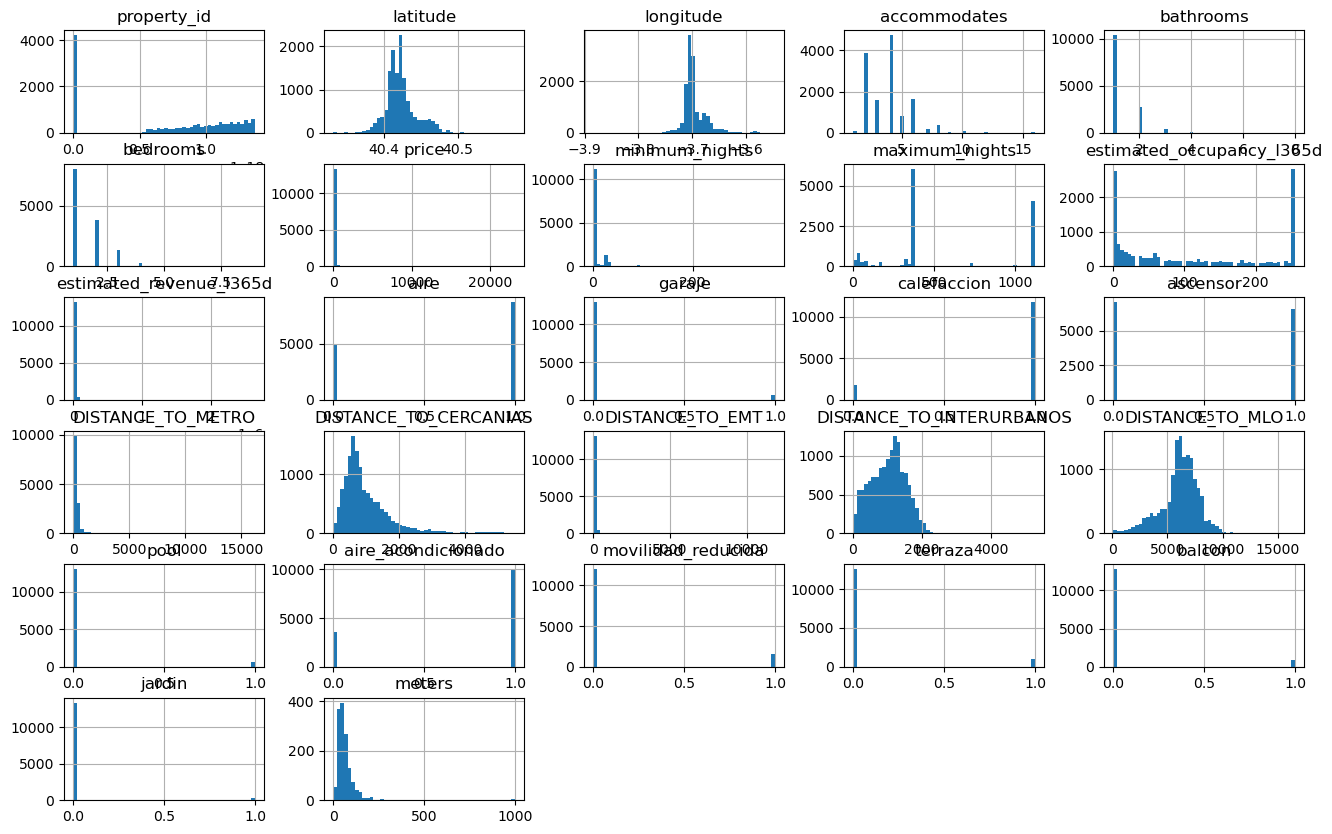

In [76]:
import matplotlib.pyplot as plt
df.hist(bins=50,figsize=(16, 10))
plt.show()

In [77]:
num_columns = df.select_dtypes(exclude='object').columns
num_columns

Index(['property_id', 'latitude', 'longitude', 'accommodates', 'bathrooms',
       'bedrooms', 'price', 'minimum_nights', 'maximum_nights',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'aire',
       'garaje', 'calefaccion', 'ascensor', 'DISTANCE_TO_METRO',
       'DISTANCE_TO_CERCANIAS', 'DISTANCE_TO_EMT', 'DISTANCE_TO_INTERURBANOS',
       'DISTANCE_TO_MLO', 'pool', 'aire_acondicionado', 'movilidad_reducida',
       'terraza', 'balcon', 'jardin', 'meters'],
      dtype='object')

In [78]:
columns_to_drop = ['property_id','listing_url','name', 'description', 'name_description','neighbourhood_cleansed','amenities','minimum_nights','maximum_nights','room_type','property_type']
df.drop(columns=columns_to_drop, inplace=True)
df.columns

Index(['neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'price', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'aire', 'garaje', 'calefaccion', 'ascensor',
       'DISTANCE_TO_METRO', 'DISTANCE_TO_CERCANIAS', 'DISTANCE_TO_EMT',
       'DISTANCE_TO_INTERURBANOS', 'DISTANCE_TO_MLO', 'pool',
       'aire_acondicionado', 'movilidad_reducida', 'terraza', 'balcon',
       'jardin', 'meters'],
      dtype='object')

In [79]:
df.isnull().sum()

neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
price                               0
estimated_occupancy_l365d           0
estimated_revenue_l365d             0
aire                                0
garaje                              0
calefaccion                         0
ascensor                            0
DISTANCE_TO_METRO                   0
DISTANCE_TO_CERCANIAS               0
DISTANCE_TO_EMT                     0
DISTANCE_TO_INTERURBANOS            0
DISTANCE_TO_MLO                     0
pool                                0
aire_acondicionado                  0
movilidad_reducida                  0
terraza                             0
balcon                              0
jardin                              0
meters                          12216
dtype: int64

In [80]:
len(df)

13634

In [81]:
df.dropna(subset=['price','estimated_revenue_l365d',], how='any', inplace=True)

In [82]:
df.isnull().sum()

neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
price                               0
estimated_occupancy_l365d           0
estimated_revenue_l365d             0
aire                                0
garaje                              0
calefaccion                         0
ascensor                            0
DISTANCE_TO_METRO                   0
DISTANCE_TO_CERCANIAS               0
DISTANCE_TO_EMT                     0
DISTANCE_TO_INTERURBANOS            0
DISTANCE_TO_MLO                     0
pool                                0
aire_acondicionado                  0
movilidad_reducida                  0
terraza                             0
balcon                              0
jardin                              0
meters                          12216
dtype: int64

In [83]:
len(df)

13634

### Movilidad Reducida

No tiene sentido, movilidad_reducida a 1 y no tener ascensor. Solo tendria sentido si el piso o casa esta en la planta baja o acceso directo desde la calle.
Eliminamos todos los registros en los que ocurra esto

In [84]:
df = df[(df["movilidad_reducida"] == 1) & (df["ascensor"] == 1) | (df["movilidad_reducida"] == 0)]

In [85]:
len(df)

12959

### neighbourhood_group_cleansed

In [86]:
df['neighbourhood_group_cleansed'].unique()

array(['Centro', 'Arganzuela', 'Chamberí', 'Fuencarral - El Pardo',
       'Hortaleza', 'Moncloa - Aravaca', 'Retiro',
       'San Blas - Canillejas', 'Barajas', 'Moratalaz', 'Ciudad Lineal',
       'Salamanca', 'Chamartín', 'Tetuán', 'Villaverde', 'Carabanchel',
       'Latina', 'Vicálvaro', 'Puente de Vallecas', 'Usera',
       'Villa de Vallecas'], dtype=object)

In [87]:
df[['neighbourhood_group_cleansed','price']].groupby('neighbourhood_group_cleansed').count()

,price
neighbourhood_group_cleansed,
Arganzuela,643
Barajas,43
Carabanchel,326
Centro,6233
Chamartín,460
Chamberí,863
Ciudad Lineal,302
Fuencarral - El Pardo,112
Hortaleza,217


In [88]:
#Calculate column 
df["price_pers"] = df['price'] / df["accommodates"]

<Axes: >

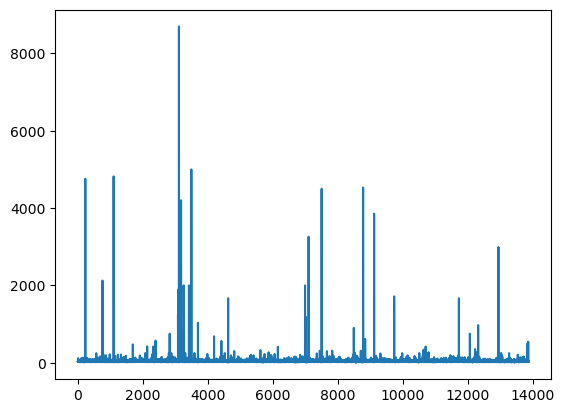

In [89]:
df["price_pers"].plot()

In [90]:
df.dtypes

neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
price                           float64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
aire                              int64
garaje                            int64
calefaccion                       int64
ascensor                          int64
DISTANCE_TO_METRO               float64
DISTANCE_TO_CERCANIAS           float64
DISTANCE_TO_EMT                 float64
DISTANCE_TO_INTERURBANOS        float64
DISTANCE_TO_MLO                 float64
pool                              int64
aire_acondicionado                int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
jardin                            int64
meters                          float64


In [91]:
df['neighbourhood_group_cleansed'].value_counts()

neighbourhood_group_cleansed
Centro                   6233
Salamanca                1049
Tetuán                    919
Chamberí                  863
Arganzuela                643
Retiro                    506
Chamartín                 460
Carabanchel               326
Ciudad Lineal             302
Puente de Vallecas        284
Moncloa - Aravaca         270
Hortaleza                 217
Usera                     202
San Blas - Canillejas     194
Latina                    194
Fuencarral - El Pardo     112
Villaverde                 67
Barajas                    43
Villa de Vallecas          34
Moratalaz                  25
Vicálvaro                  16
Name: count, dtype: int64

<Axes: xlabel='neighbourhood_group_cleansed'>

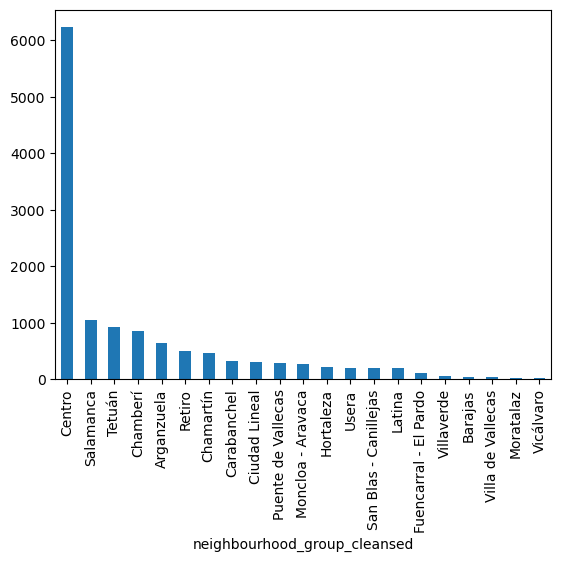

In [92]:
df['neighbourhood_group_cleansed'].value_counts().plot.bar()

<Axes: xlabel='bedrooms'>

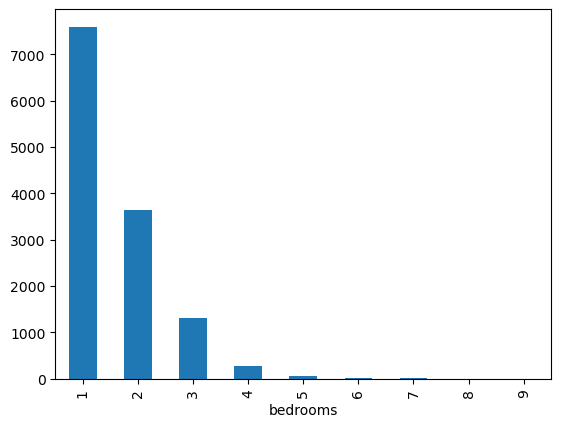

In [93]:
df["bedrooms"].value_counts().plot.bar()

<Axes: xlabel='bathrooms'>

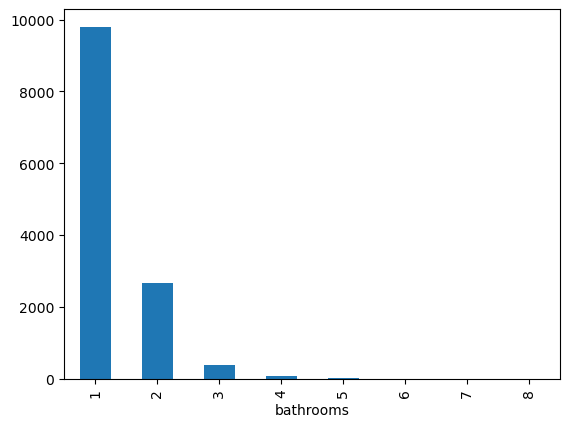

In [94]:
df["bathrooms"].value_counts().plot.bar()

#### New Colunm distance_to_center

In [95]:
center_lat, center_lon = 40.4168, -3.7038

# Create distance to city center
df['distance_to_center'] = np.sqrt((df['latitude'] - center_lat)**2 + (df['longitude'] - center_lon)**2)

#### New Column bath_bed_ratio

In [96]:
df["bath_bed_ratio"] = df["bathrooms"] / df["bedrooms"]

#### New Column renta_bin

In [97]:
df["renta_bin"] = df['neighbourhood_group_cleansed'].apply(lambda x: get_renta_bin(x))

#### New Column es_Centro

In [98]:
def get_es_Centro(neighbourhood):
    if neighbourhood == 'Centro':
        return 1
    return 0

In [99]:
df["es_centro"] = df['neighbourhood_group_cleansed'].apply(lambda x: get_es_Centro(x))

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12959 entries, 0 to 13870
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  12959 non-null  object 
 1   latitude                      12959 non-null  float64
 2   longitude                     12959 non-null  float64
 3   accommodates                  12959 non-null  int64  
 4   bathrooms                     12959 non-null  int64  
 5   bedrooms                      12959 non-null  int64  
 6   price                         12959 non-null  float64
 7   estimated_occupancy_l365d     12959 non-null  int64  
 8   estimated_revenue_l365d       12959 non-null  float64
 9   aire                          12959 non-null  int64  
 10  garaje                        12959 non-null  int64  
 11  calefaccion                   12959 non-null  int64  
 12  ascensor                      12959 non-null  int64  
 13  DISTAN

#### New Column nearest_metro_distance

##### Calculo de distancia Ubicacion Alojamiento - Estacion de Metro

#### Outliers

In [101]:
df_numerics_Q1 = df[['price_pers']].apply(lambda x: np.quantile(x,q=.25)) # indicadores de Q1
df_numerics_Q3 = df[['price_pers']].apply(lambda x: np.quantile(x,q=.75)) # indicadores de Q2
df_numerics_IQR = df_numerics_Q3 - df_numerics_Q1 # longitud del IQR
df_numerics_lower = df_numerics_Q1 - 1.5 * df_numerics_IQR # limite inferior
df_numerics_upper = df_numerics_Q3 + 1.5 * df_numerics_IQR # limite superior
print(f"Outliers: Low:{df_numerics_lower} High:{df_numerics_upper}")

Outliers: Low:price_pers   -6.75
dtype: float64 High:price_pers    79.25
dtype: float64


In [102]:
df.shape

(12959, 30)

In [103]:
df_numerics_over_max = df[['price_pers']].apply(lambda x: x> df_numerics_upper,axis=1) # comprobamos que valores están por encima del máximo
df_numerics_below_min = df[['price_pers']].apply(lambda x: x< df_numerics_lower,axis=1) # comprobamos que valores están por encima del máximo
pd.DataFrame({"outlier_below":df_numerics_below_min.sum(),
              "outlier_above":df_numerics_over_max.sum()})

,outlier_below,outlier_above
price_pers,0,604


In [104]:
samples_with_outliers_price_pers = df_numerics_below_min.any(axis=1) | df_numerics_over_max.any(axis=1)

In [105]:
df_with_outliers = df[samples_with_outliers_price_pers]

<Axes: title={'center': 'Muestras con outliers'}, xlabel='bedrooms', ylabel='price_pers'>

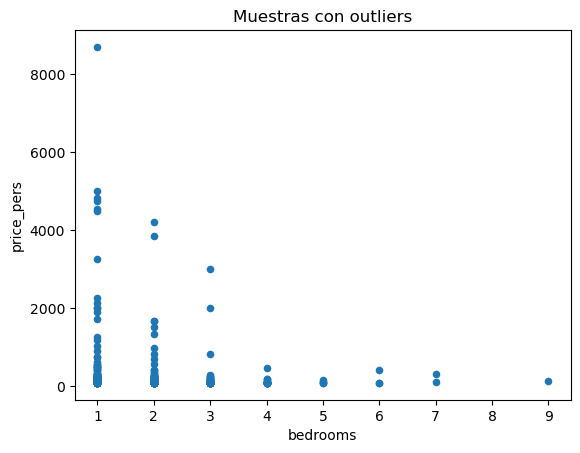

In [106]:
# Exploración de las muestras con outliers,
df_with_outliers.plot.scatter(x="bedrooms",y="price_pers", title="Muestras con outliers")

<Axes: title={'center': 'Muestras sin outliers Clásicos'}, xlabel='bedrooms', ylabel='price_pers'>

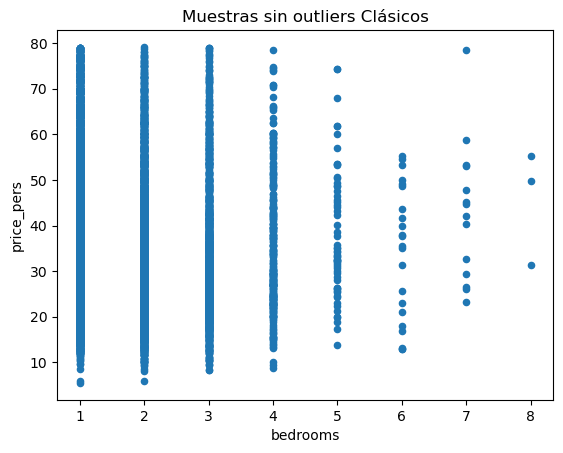

In [107]:
# Exploración de las muestras sin outliers,
df[~samples_with_outliers_price_pers].plot.scatter(x="bedrooms",y="price_pers", title="Muestras sin outliers Clásicos")

In [108]:
df = df[~samples_with_outliers_price_pers]

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12355 entries, 0 to 13870
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  12355 non-null  object 
 1   latitude                      12355 non-null  float64
 2   longitude                     12355 non-null  float64
 3   accommodates                  12355 non-null  int64  
 4   bathrooms                     12355 non-null  int64  
 5   bedrooms                      12355 non-null  int64  
 6   price                         12355 non-null  float64
 7   estimated_occupancy_l365d     12355 non-null  int64  
 8   estimated_revenue_l365d       12355 non-null  float64
 9   aire                          12355 non-null  int64  
 10  garaje                        12355 non-null  int64  
 11  calefaccion                   12355 non-null  int64  
 12  ascensor                      12355 non-null  int64  
 13  DISTAN

## Models

Model not considerating meters, we are going to create a model to predict the price per night

### Model 007

renta_bin y distance_center y considerando otros outliers en precio

In [110]:
dfm = df.copy()

In [111]:
dfm.dtypes

neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
price                           float64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
aire                              int64
garaje                            int64
calefaccion                       int64
ascensor                          int64
DISTANCE_TO_METRO               float64
DISTANCE_TO_CERCANIAS           float64
DISTANCE_TO_EMT                 float64
DISTANCE_TO_INTERURBANOS        float64
DISTANCE_TO_MLO                 float64
pool                              int64
aire_acondicionado                int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
jardin                            int64
meters                          float64


In [112]:
dfm.shape

(12355, 30)

In [113]:
dfm.columns

Index(['neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'price', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'aire', 'garaje', 'calefaccion', 'ascensor',
       'DISTANCE_TO_METRO', 'DISTANCE_TO_CERCANIAS', 'DISTANCE_TO_EMT',
       'DISTANCE_TO_INTERURBANOS', 'DISTANCE_TO_MLO', 'pool',
       'aire_acondicionado', 'movilidad_reducida', 'terraza', 'balcon',
       'jardin', 'meters', 'price_pers', 'distance_to_center',
       'bath_bed_ratio', 'renta_bin', 'es_centro'],
      dtype='object')

In [114]:
dfm = dfm[['bedrooms','accommodates','bathrooms','price','renta_bin','garaje','ascensor','pool','terraza','balcon','distance_to_center','aire_acondicionado','movilidad_reducida','jardin','DISTANCE_TO_METRO', 'DISTANCE_TO_CERCANIAS', 'DISTANCE_TO_EMT',
       'DISTANCE_TO_INTERURBANOS', 'DISTANCE_TO_MLO']]

In [115]:
dfm.dtypes

bedrooms                      int64
accommodates                  int64
bathrooms                     int64
price                       float64
renta_bin                    object
garaje                        int64
ascensor                      int64
pool                          int64
terraza                       int64
balcon                        int64
distance_to_center          float64
aire_acondicionado            int64
movilidad_reducida            int64
jardin                        int64
DISTANCE_TO_METRO           float64
DISTANCE_TO_CERCANIAS       float64
DISTANCE_TO_EMT             float64
DISTANCE_TO_INTERURBANOS    float64
DISTANCE_TO_MLO             float64
dtype: object

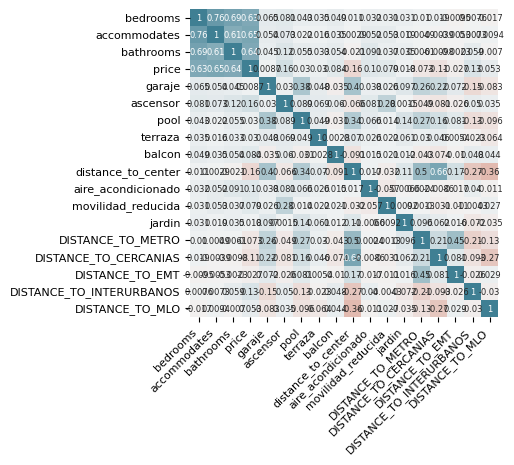

In [116]:
import seaborn as sns

corr_matrix = dfm.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

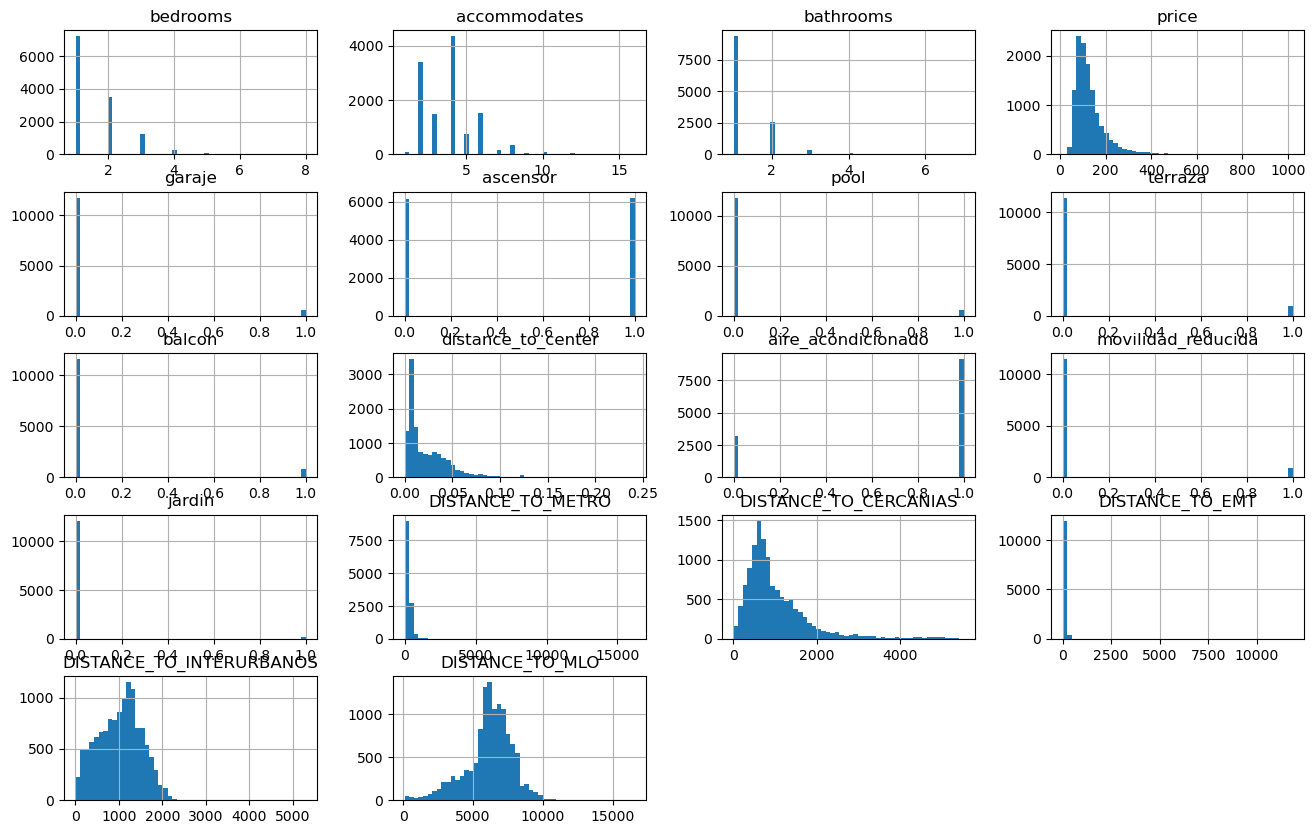

In [117]:
#Histogram of all numeric values
dfm.hist(bins=50, figsize=(16,10))
plt.show()

In [118]:
dfm.shape

(12355, 19)

In [119]:
from scipy.stats import zscore
data = np.array(dfm["price"])
z_scores = zscore(data)
z_scores

array([-0.87335185, -0.57009942,  0.5374312 , ..., -0.38551098,
       -0.42506565, -0.87335185])

In [120]:
outliers = data[np.abs(z_scores) > 3]
print("Outliers:", outliers)

Outliers: [ 385.  375.  444.  884.  363.  456.  361.  418.  672.  507.  371.  396.
  455.  543.  618.  457.  399.  571.  391.  482.  404.  486.  379.  720.
  500.  851.  388.  370.  513.  416.  402.  509.  608.  364.  485.  604.
  515.  409.  475.  448.  523.  604.  415.  372.  587.  447.  470.  438.
  552.  397.  363.  399.  381.  365.  458.  366.  724.  429.  422.  399.
  389.  391.  465.  597.  411.  380.  375.  392.  691.  368.  672.  571.
  462.  569.  392.  547.  592.  375.  363.  418.  407.  361.  360.  392.
  361. 1021.  384.  450.  468.  406.  743.  500.  383.  361.  364.  391.
  382.  364.  373.  453.  398.  434.  489.  439.  360.  386.  420.  606.
  529.  429.  563.  465.  498.  519.  393.  377.  376.  473.  380.  407.
  379.  743.  438.  392.  414.  567.  528.  425.  611.  523.  462.  602.
  474.  375.  560.  400.  395.  688.  386.  392.  422.  503.  547.  363.
  478.  411.  680.  394.  450.  473.  384.  360.  456.  460.  362.  398.
  436.  360.  429.  429.  429.  389.  851

In [121]:
dfm = dfm[~dfm['price'].isin(outliers)]
dfm.shape

(12086, 19)

{'whiskers': [<matplotlib.lines.Line2D at 0x1736c3590>,
 'caps': [<matplotlib.lines.Line2D at 0x1736c3fb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1736c22d0>],
 'medians': [<matplotlib.lines.Line2D at 0x17513c7a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x17513cb90>],
 'means': []}

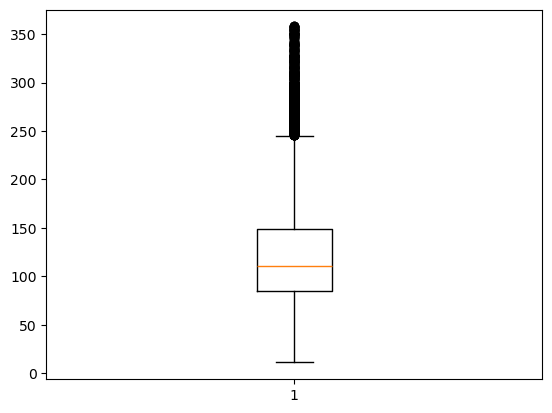

In [122]:
plt.boxplot(dfm["price"])

In [123]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [124]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [125]:


numerical_features = ['bedrooms','bathrooms','distance_to_center','DISTANCE_TO_METRO', 'DISTANCE_TO_CERCANIAS', 'DISTANCE_TO_EMT','DISTANCE_TO_INTERURBANOS', 'DISTANCE_TO_MLO']#X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

In [126]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [127]:
model = linear_model.Ridge(alpha=9.3)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)

In [128]:
mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
r2 = metrics.r2_score(y_train, y_train_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.5020805778999381 mse: 1562.443199220706 rmse: 39.52775226623323 mape: 0.25239398688029563


In [129]:
cv_scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-40.54713149 -39.97817295 -37.31803396 -39.61704041 -40.65631979]
Média métricas de validación cruzada: -39.62333972048753


In [130]:
get_results(X_train, y_train, X_test, y_test)

100%|██████████| 6/6 [00:00<00:00, 59.12it/s]


,r2,mse,rmse,mape
lr,0.486874,1607.283025,40.090934,0.252750
ridge,0.486874,1607.283025,40.090934,0.252750
lasso,0.468187,1665.816529,40.814416,0.259451
SGD,0.486377,1608.839668,40.110344,0.252255
HuberRegressor,0.477801,1635.704107,40.443839,0.240878
Elastic,0.448174,1728.505338,41.575297,0.267315


### Model 008

Mismo modelo que Model008 pero añadiendo la columna distancia a estacion del metro y modelo SVR


In [131]:
dfm = df.copy()

In [132]:
dfm.shape

(12355, 30)

In [133]:
#'jardin'
dfm = dfm[['bedrooms','bathrooms','price','renta_bin','ascensor','garaje','pool','terraza','balcon','distance_to_center','aire_acondicionado','movilidad_reducida','calefaccion','DISTANCE_TO_METRO', 'DISTANCE_TO_CERCANIAS', 'DISTANCE_TO_EMT',
       'DISTANCE_TO_INTERURBANOS', 'DISTANCE_TO_MLO']]

In [134]:
dfm.rename(columns={'DISTANCE_TO_METRO':'distance_to_metro',
    'DISTANCE_TO_CERCANIAS':'distance_to_cercanias',
    'DISTANCE_TO_EMT':'distance_to_emt',
    'DISTANCE_TO_INTERURBANOS':'distance_to_interurbanos',
    'DISTANCE_TO_MLO':'distance_to_mlo'}, inplace=True)

In [135]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12355 entries, 0 to 13870
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bedrooms                  12355 non-null  int64  
 1   bathrooms                 12355 non-null  int64  
 2   price                     12355 non-null  float64
 3   renta_bin                 12355 non-null  object 
 4   ascensor                  12355 non-null  int64  
 5   garaje                    12355 non-null  int64  
 6   pool                      12355 non-null  int64  
 7   terraza                   12355 non-null  int64  
 8   balcon                    12355 non-null  int64  
 9   distance_to_center        12355 non-null  float64
 10  aire_acondicionado        12355 non-null  int64  
 11  movilidad_reducida        12355 non-null  int64  
 12  calefaccion               12355 non-null  int64  
 13  distance_to_metro         12355 non-null  float64
 14  distance_to

In [136]:
from scipy.stats import zscore
data = np.array(dfm["price"])
z_scores = zscore(data)
z_scores

array([-0.87335185, -0.57009942,  0.5374312 , ..., -0.38551098,
       -0.42506565, -0.87335185])

In [137]:
outliers = data[np.abs(z_scores) > 3]
print("Outliers:", outliers)

Outliers: [ 385.  375.  444.  884.  363.  456.  361.  418.  672.  507.  371.  396.
  455.  543.  618.  457.  399.  571.  391.  482.  404.  486.  379.  720.
  500.  851.  388.  370.  513.  416.  402.  509.  608.  364.  485.  604.
  515.  409.  475.  448.  523.  604.  415.  372.  587.  447.  470.  438.
  552.  397.  363.  399.  381.  365.  458.  366.  724.  429.  422.  399.
  389.  391.  465.  597.  411.  380.  375.  392.  691.  368.  672.  571.
  462.  569.  392.  547.  592.  375.  363.  418.  407.  361.  360.  392.
  361. 1021.  384.  450.  468.  406.  743.  500.  383.  361.  364.  391.
  382.  364.  373.  453.  398.  434.  489.  439.  360.  386.  420.  606.
  529.  429.  563.  465.  498.  519.  393.  377.  376.  473.  380.  407.
  379.  743.  438.  392.  414.  567.  528.  425.  611.  523.  462.  602.
  474.  375.  560.  400.  395.  688.  386.  392.  422.  503.  547.  363.
  478.  411.  680.  394.  450.  473.  384.  360.  456.  460.  362.  398.
  436.  360.  429.  429.  429.  389.  851

In [138]:
dfm = dfm[~dfm['price'].isin(outliers)]
dfm.shape

(12086, 18)

In [139]:
dfm.dtypes

bedrooms                      int64
bathrooms                     int64
price                       float64
renta_bin                    object
ascensor                      int64
garaje                        int64
pool                          int64
terraza                       int64
balcon                        int64
distance_to_center          float64
aire_acondicionado            int64
movilidad_reducida            int64
calefaccion                   int64
distance_to_metro           float64
distance_to_cercanias       float64
distance_to_emt             float64
distance_to_interurbanos    float64
distance_to_mlo             float64
dtype: object

In [140]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [141]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [142]:


numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

In [143]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [144]:
get_results(X_train, y_train, X_test, y_test)

100%|██████████| 6/6 [00:00<00:00, 61.50it/s]


,r2,mse,rmse,mape
lr,0.451927,1716.749992,41.433682,0.264839
ridge,0.451927,1716.749992,41.433682,0.264839
lasso,0.439512,1755.636252,41.900313,0.270016
SGD,0.448517,1727.431538,41.562381,0.267454
HuberRegressor,0.441826,1748.388473,41.813735,0.251538
Elastic,0.414059,1835.365436,42.841165,0.280284


In [145]:
from sklearn.svm import SVR
#model = SVR(kernel='rbf', C=1.0, epsilon=0.1,gamma=0.1)
model = SVR(kernel='linear', C=1.0, epsilon=0.1)
#reg_cv = GridSearchCV(model, {"C":[0.1,1.0,10.0],"epsilon":[0.1,0.2,0.3],"gamma":[0.1,0.2,0.3]}, verbose=1)
reg_cv = GridSearchCV(model, {"C":[0.1,1.0,10.0],"epsilon":[0.1,0.2,0.3]}, verbose=1)
reg_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=SVR(kernel='linear'),
             param_grid={'C': [0.1, 1.0, 10.0], 'epsilon': [0.1, 0.2, 0.3]},
             verbose=1)

In [146]:
reg_cv.best_params_

{'C': 10.0, 'epsilon': 0.3}

In [147]:
model = SVR(**reg_cv.best_params_)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)

In [148]:

num_features = numerical_features.tolist()

# Extract names from one-hot encoded categorical features
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_feature)

# Combine all names
feature_names = num_features + list(cat_feature_names)


In [149]:
mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
r2 = metrics.r2_score(y_train, y_train_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4938606389140239 mse: 1588.236906387987 rmse: 39.85269007718283 mape: 0.22995943577307254


In [150]:
cv_scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-41.84937843 -40.91088095 -39.8569042  -40.40880067 -42.34309793]
Média métricas de validación cruzada: -41.07381243631385


In [151]:
y_test_pred = model.predict(X_test)
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

In [152]:
mse = metrics.mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
r2 = metrics.r2_score(y_test, y_test_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.44917331392991666 mse: 1725.3746671069762 rmse: 41.53762953163043 mape: 0.24013611464624426


In [153]:
train_predict_analysis.head(20)

,y,y_pred
6448,83.0,113.701583
5513,106.0,108.811186
10081,147.0,125.011165
10813,110.0,113.151842
5464,342.0,228.673309
3121,102.0,98.343097
13390,79.0,143.803558
1533,70.0,88.525036
8731,127.0,155.363981
3858,211.0,185.750908


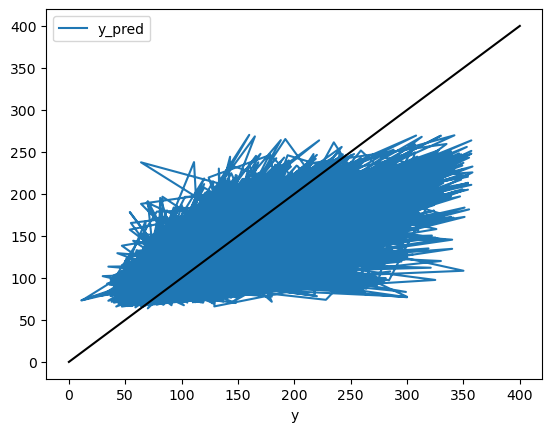

In [154]:
train_predict_analysis.plot.line(x="y",y="y_pred")
plt.plot((0,400),(0,400),c="k")

In [155]:
train_predict_analysis["y_pred_diff"]=train_predict_analysis["y_pred"]-train_predict_analysis["y"]

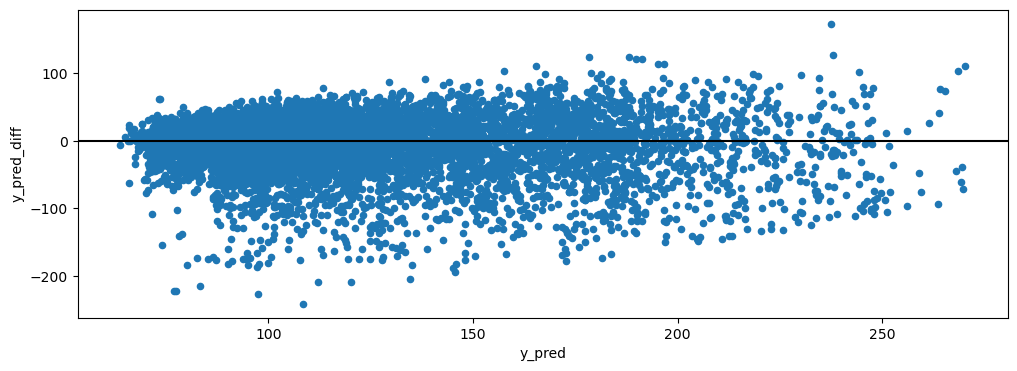

In [156]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")

In [157]:
#To Generate the model
import skops.io as sio

sio.dump(model,"../../model/model.skops")
